# 5. Intraday Patterns Analysis

This notebook analyzes intraday trading patterns in NVDA data, including:
- Hourly return and volatility patterns
- Market open/close effects
- Extended hours vs regular hours analysis
- U-shaped volatility patterns
- Trading activity by time of day


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the cleaned data
all_data = pd.read_csv('combined_nvda_ohlc_clean.csv')
all_data['date'] = pd.to_datetime(all_data['date'])
all_data['datetime'] = pd.to_datetime(all_data['datetime'])

# Calculate returns
all_data_sorted = all_data.sort_values('datetime').reset_index(drop=True)
all_data_sorted['returns'] = all_data_sorted['close'].pct_change()
returns_with_time = all_data_sorted[['datetime', 'returns']].dropna()

print(f"Loaded data shape: {all_data.shape}")
print(f"Returns with time: {len(returns_with_time):,} observations")


Loaded data shape: (865782, 13)
Returns with time: 865,781 observations


In [2]:
# Extract hour and minute from datetime
returns_with_time['hour'] = returns_with_time['datetime'].dt.hour
returns_with_time['minute'] = returns_with_time['datetime'].dt.minute

# Calculate average returns and volatility by hour
hourly_stats = returns_with_time.groupby('hour')['returns'].agg(['mean', 'std', 'count'])
hourly_stats.columns = ['mean_return', 'volatility', 'count']

# Convert to percentage for readability
hourly_stats['mean_return_pct'] = hourly_stats['mean_return'] * 100
hourly_stats['volatility_pct'] = hourly_stats['volatility'] * 100

print("=== INTRADAY PATTERNS ANALYSIS ===")
print("Average returns and volatility by hour of day:")
print(hourly_stats)


=== INTRADAY PATTERNS ANALYSIS ===
Average returns and volatility by hour of day:
       mean_return  volatility  count  mean_return_pct  volatility_pct
hour                                                                  
4     3.716344e-05    0.001979  37932         0.003716        0.197925
5    -4.265209e-07    0.000826  31245        -0.000043        0.082646
6    -4.461722e-06    0.000857  31661        -0.000446        0.085660
7     7.969684e-06    0.000820  51068         0.000797        0.082024
8     1.347858e-06    0.001605  59768         0.000135        0.160452
9     2.519609e-06    0.002055  64205         0.000252        0.205489
10   -4.794198e-06    0.001640  66420        -0.000479        0.163972
11    8.232062e-06    0.001202  66419         0.000823        0.120240
12   -1.078491e-06    0.001005  66420        -0.000108        0.100459
13    6.524401e-06    0.000955  66005         0.000652        0.095483
14    1.006020e-05    0.001029  65998         0.001006        0.10

In [3]:
# Market open and close effects
print(f"\n=== MARKET OPEN/CLOSE EFFECTS ===")
print("First 30 minutes (9:30-10:00 AM):")
first_30min = returns_with_time[(returns_with_time['hour'] == 9) | 
                               ((returns_with_time['hour'] == 10) & (returns_with_time['minute'] < 30))]
print(f"  Mean return: {first_30min['returns'].mean()*100:.4f}%")
print(f"  Volatility: {first_30min['returns'].std()*100:.4f}%")
print(f"  Count: {len(first_30min):,}")

print("\nLast 30 minutes (3:30-4:00 PM):")
last_30min = returns_with_time[(returns_with_time['hour'] == 15) & (returns_with_time['minute'] >= 30) |
                              (returns_with_time['hour'] == 16)]
print(f"  Mean return: {last_30min['returns'].mean()*100:.4f}%")
print(f"  Volatility: {last_30min['returns'].std()*100:.4f}%")
print(f"  Count: {len(last_30min):,}")

print("\nMidday (11:00 AM - 2:00 PM):")
midday = returns_with_time[(returns_with_time['hour'] >= 11) & (returns_with_time['hour'] < 14)]
print(f"  Mean return: {midday['returns'].mean()*100:.4f}%")
print(f"  Volatility: {midday['returns'].std()*100:.4f}%")
print(f"  Count: {len(midday):,}")



=== MARKET OPEN/CLOSE EFFECTS ===
First 30 minutes (9:30-10:00 AM):
  Mean return: -0.0000%
  Volatility: 0.1976%
  Count: 97,415

Last 30 minutes (3:30-4:00 PM):
  Mean return: 0.0004%
  Volatility: 0.1321%
  Count: 88,715

Midday (11:00 AM - 2:00 PM):
  Mean return: 0.0005%
  Volatility: 0.1060%
  Count: 198,844


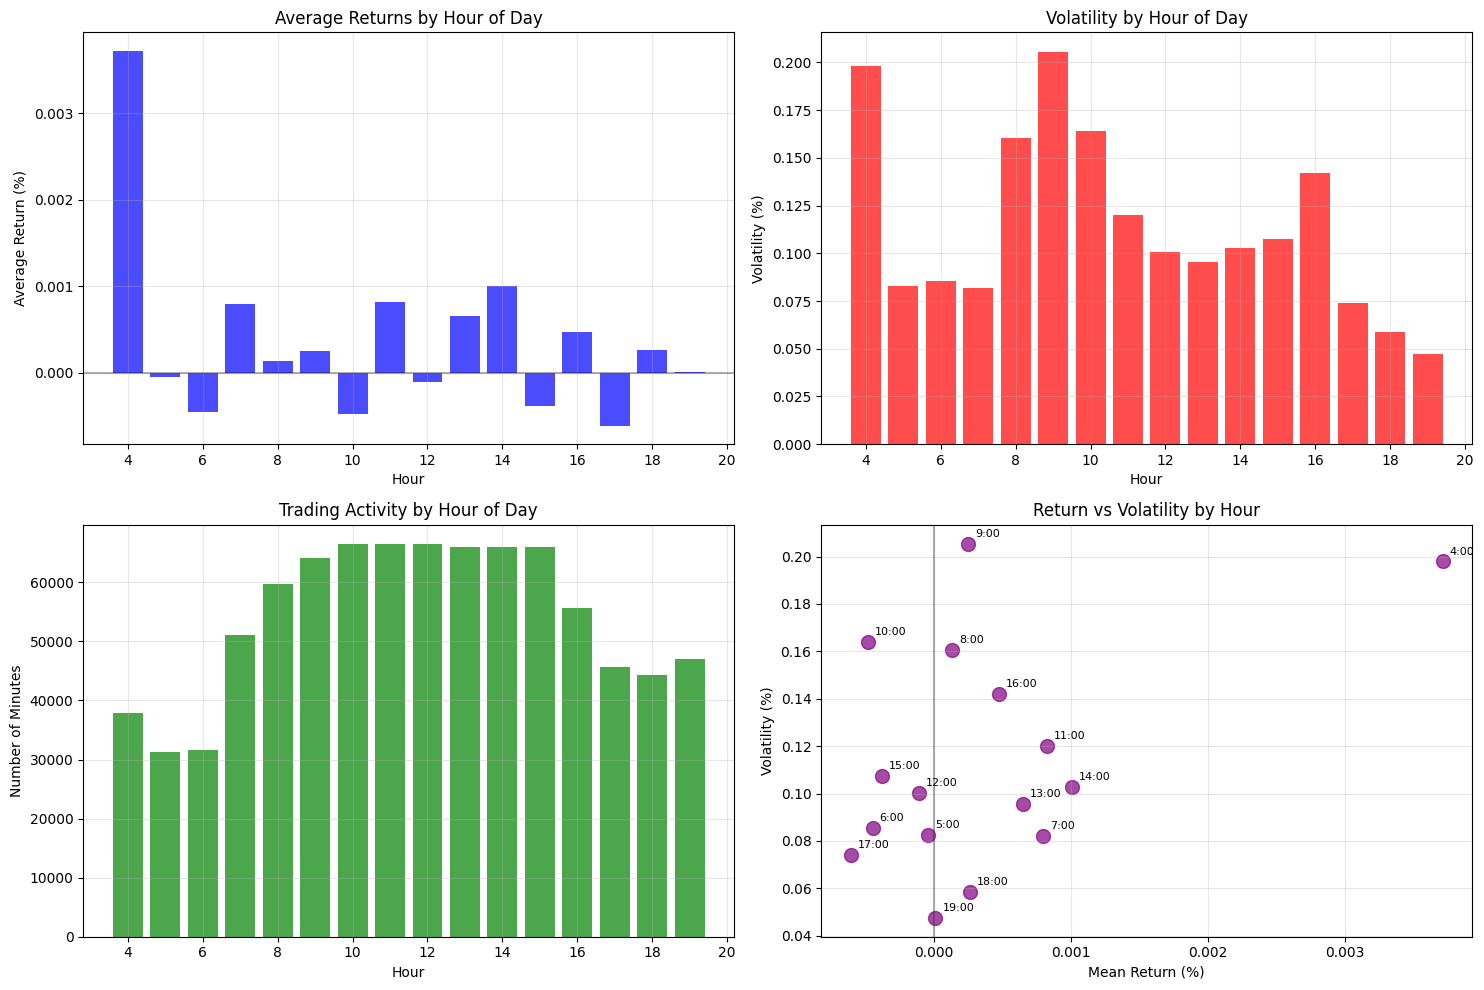

In [4]:
# Plot intraday patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Average returns by hour
axes[0, 0].bar(hourly_stats.index, hourly_stats['mean_return_pct'], alpha=0.7, color='blue')
axes[0, 0].set_title('Average Returns by Hour of Day')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Average Return (%)')
axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 0].grid(True, alpha=0.3)

# Volatility by hour
axes[0, 1].bar(hourly_stats.index, hourly_stats['volatility_pct'], alpha=0.7, color='red')
axes[0, 1].set_title('Volatility by Hour of Day')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Volatility (%)')
axes[0, 1].grid(True, alpha=0.3)

# Trading activity by hour
axes[1, 0].bar(hourly_stats.index, hourly_stats['count'], alpha=0.7, color='green')
axes[1, 0].set_title('Trading Activity by Hour of Day')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Number of Minutes')
axes[1, 0].grid(True, alpha=0.3)

# Combined view: volatility vs returns
axes[1, 1].scatter(hourly_stats['mean_return_pct'], hourly_stats['volatility_pct'], 
                  s=100, alpha=0.7, color='purple')
for hour, row in hourly_stats.iterrows():
    axes[1, 1].annotate(f'{hour}:00', (row['mean_return_pct'], row['volatility_pct']), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1, 1].set_title('Return vs Volatility by Hour')
axes[1, 1].set_xlabel('Mean Return (%)')
axes[1, 1].set_ylabel('Volatility (%)')
axes[1, 1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [5]:
# Extended hours analysis
print(f"\n=== EXTENDED HOURS ANALYSIS ===")
regular_hours = returns_with_time[(returns_with_time['hour'] >= 9) & (returns_with_time['hour'] < 16)]
extended_hours = returns_with_time[(returns_with_time['hour'] < 9) | (returns_with_time['hour'] >= 16)]

print("Regular hours (9:00 AM - 4:00 PM):")
print(f"  Mean return: {regular_hours['returns'].mean()*100:.4f}%")
print(f"  Volatility: {regular_hours['returns'].std()*100:.4f}%")
print(f"  Count: {len(regular_hours):,}")

print("Extended hours (pre-market + after-hours):")
print(f"  Mean return: {extended_hours['returns'].mean()*100:.4f}%")
print(f"  Volatility: {extended_hours['returns'].std()*100:.4f}%")
print(f"  Count: {len(extended_hours):,}")

# Calculate percentage split
total_records = len(returns_with_time)
regular_pct = len(regular_hours) / total_records * 100
extended_pct = len(extended_hours) / total_records * 100

print(f"\nTrading session breakdown:")
print(f"  Regular hours: {regular_pct:.1f}% of all trading")
print(f"  Extended hours: {extended_pct:.1f}% of all trading")



=== EXTENDED HOURS ANALYSIS ===
Regular hours (9:00 AM - 4:00 PM):
  Mean return: 0.0003%
  Volatility: 0.1332%
  Count: 461,467
Extended hours (pre-market + after-hours):
  Mean return: 0.0005%
  Volatility: 0.1161%
  Count: 404,314

Trading session breakdown:
  Regular hours: 53.3% of all trading
  Extended hours: 46.7% of all trading
